## Clusterización

En este caso práctico aplicaremos el algoritmos de clusterización para hacer agrupamiento de datos, aprenderemos cómo funcionan y cómo utilizarlos en un caso práctico

El caso estará estructurado así
1. Hacer un análisis exploratorio para revisar la estructura de los datos
2. Usar lo que observamos para guiar nuestro proceso de agrupamiento
3. Ajustar un algortimo de k-means a los datos disponibles
4. Ajustar un agrupamiento jerárquico
5. Hacer segmentaciones y conclusiones a partir del análisis

**Contexto:** Las competencias deportivas cada día recogen una gran cantidad de datos relacionados con el desempeño de sus equipos y jugadores para encontrar patrones en estos datos y tomar decisiones informadas basadas en ellos. De esta manera la competencia aumenta tanto dentro como fuera de la cancha

**Problema de negocio:** Se tienen los datos de desempeño de los equipos de baloncesto del torneo NCAA March Madness que contiene las estadísticas de juego de 353 equipos de la liga. El objetivo es inspeccionar esta data utilizando técnicas de visualización y agrupación para encontrar patrones en el desempeño de los equipos y generar recomendaciones de umbrales en las estadísticas para que un equipo esté en el grupo de desempeño superior.

In [1]:
# librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# display setting Para visualizar el máximo de columnas
pd.set_option('display.max_columns', None)

In [3]:
datos = pd.read_csv('data/basketball_19.csv')

In [4]:
datos.columns

Index(['TEAM', 'CONF', 'G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D',
       'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O',
       '3P_D', 'ADJ_T', 'WAB', 'POSTSEASON', 'SEED'],
      dtype='object')

## Datos

Estas son las variables que contiene el conjunto de datos 

- **TEAM:** Equipo
- **CONF:** La conferencia en la que el equipo participa(A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)
- **G:** Número de partidos jugados
- **W:** Número de partidos ganados
- **ADJOE:** Estimación de eficiencia ofensiva, puntos anotados por cada 100 posesiones
- **ADJDE:** Estimación de eficiencia defensiva, puntos permitidos por cada 100 posesiones del equipo contrario
- **BARTHAG:** Probabilidad de vencer a un equipo
- **EFG_O:** Effective Field Goal Percentage Shot
- **EFG_D:** Effective Field Goal Percentage Allowed
- **TOR:** Porcentaje de rotación permitida (equipo pierde la posesión del balón contra el equipo contrario antes de que un jugador dispare a la canasta de su equipo)
- **TORD:** Porcentaje de rotación hecha al equipo contrario (se roba la pelota al contrincante)
- **ORB:** Porcentaje de rebote ofensivo
- **B:** Porcentaje de rebote defensivo
- **FTR:** Tasa de tiros libres hechos(que hace el equipo)
- **FTRD:** Tasa de tiros libres permitidos (que hace el contrincante)
- **2P_O:** Porcentaje de tiros de 2 puntos hechos
- **2P_D:** Porcentaje de tiros de 2 puntos permitidos
- **3P_O:** Porcentaje de tiros de 3 puntos hechos
- **3P_D:** Porcentaje de tiros de 3 puntos permitidos
- **ADJ_T:** Posesión del balón por 40 min
- **WAB:** Triunfos por encima de la 'burbuja' (la burbuja es el límite definido para pasar al campeonato NCAA March Madness Tournament
- **POSTSEASON:** Ronda en la que el equipo de fue eliminado (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)
- **SEED:**Semilla definida por el torneo

In [5]:
datos.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED
0,Gonzaga,WCC,37,33,123.4,89.9,0.9744,59.0,44.2,14.9,19.0,31.5,26.8,35.3,25.9,61.4,43.4,36.3,30.4,72.0,7.0,E8,1.0
1,Virginia,ACC,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,17.5,30.4,25.4,29.1,26.3,52.5,45.7,39.5,28.9,60.7,11.1,Champions,1.0
2,Duke,ACC,38,32,118.9,89.2,0.9646,53.6,45.0,17.5,19.4,35.6,29.5,33.2,24.0,58.0,45.0,30.8,29.9,73.6,11.2,E8,1.0
3,North Carolina,ACC,36,29,120.1,91.4,0.9582,52.9,48.9,17.2,18.3,35.3,22.8,30.2,28.4,52.1,47.9,36.2,33.5,76.0,10.0,S16,1.0
4,Michigan,B10,37,30,114.6,85.6,0.9665,51.6,44.1,13.9,18.0,24.7,24.8,27.5,24.1,51.8,44.3,34.2,29.1,65.9,9.2,S16,2.0


## Exploración de los datos 

Para empezar el análisis hay que hacer una exploración inicial de los datos, entender un poco las variables y la información que tenemos. Para empezar nuestros datos consisten en las estadísticas de 353 equipos contenidas en 23 variables 

In [6]:
datos.shape

(353, 23)

In [7]:
datos.describe()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,68.000000
mean,31.745042,17.113314,103.335977,103.336261,0.493214,50.600850,50.774504,18.606516,18.523513,28.245892,28.420397,32.954391,33.202550,50.060057,50.233994,34.287819,34.415864,69.168555,-7.783569,8.794118
std,2.514195,6.374993,7.020019,6.452597,0.253006,2.938629,2.752896,2.066711,2.092719,3.938373,2.923335,4.708719,5.080133,3.362801,3.122286,2.537098,2.336075,2.694397,7.120550,4.698551
min,26.000000,3.000000,83.700000,85.200000,0.034600,40.000000,42.500000,13.500000,13.300000,15.900000,21.700000,21.900000,21.800000,37.700000,40.700000,27.900000,27.900000,60.700000,-23.400000,1.000000
25%,30.000000,12.000000,98.600000,98.700000,0.281400,48.800000,48.900000,17.200000,17.100000,25.400000,26.300000,29.900000,29.700000,47.700000,48.300000,32.400000,32.900000,67.300000,-13.100000,5.000000
50%,31.000000,17.000000,103.100000,104.000000,0.476200,50.500000,50.900000,18.500000,18.300000,28.300000,28.300000,33.300000,32.700000,50.300000,50.200000,34.200000,34.400000,69.000000,-8.600000,9.000000
75%,33.000000,21.000000,107.700000,107.800000,0.689300,52.800000,52.600000,19.800000,19.800000,31.000000,30.400000,35.900000,36.400000,52.200000,52.200000,36.000000,35.900000,70.800000,-3.100000,13.000000
max,39.000000,35.000000,123.400000,119.200000,0.974400,59.000000,59.300000,25.100000,24.700000,38.700000,37.100000,48.100000,54.000000,61.400000,61.200000,42.400000,41.800000,79.100000,11.200000,16.000000


Visualicemos el comportamiento de algunas variables

In [8]:
columnas = ['G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D',
       'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O',
       '3P_D', 'ADJ_T', 'WAB']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


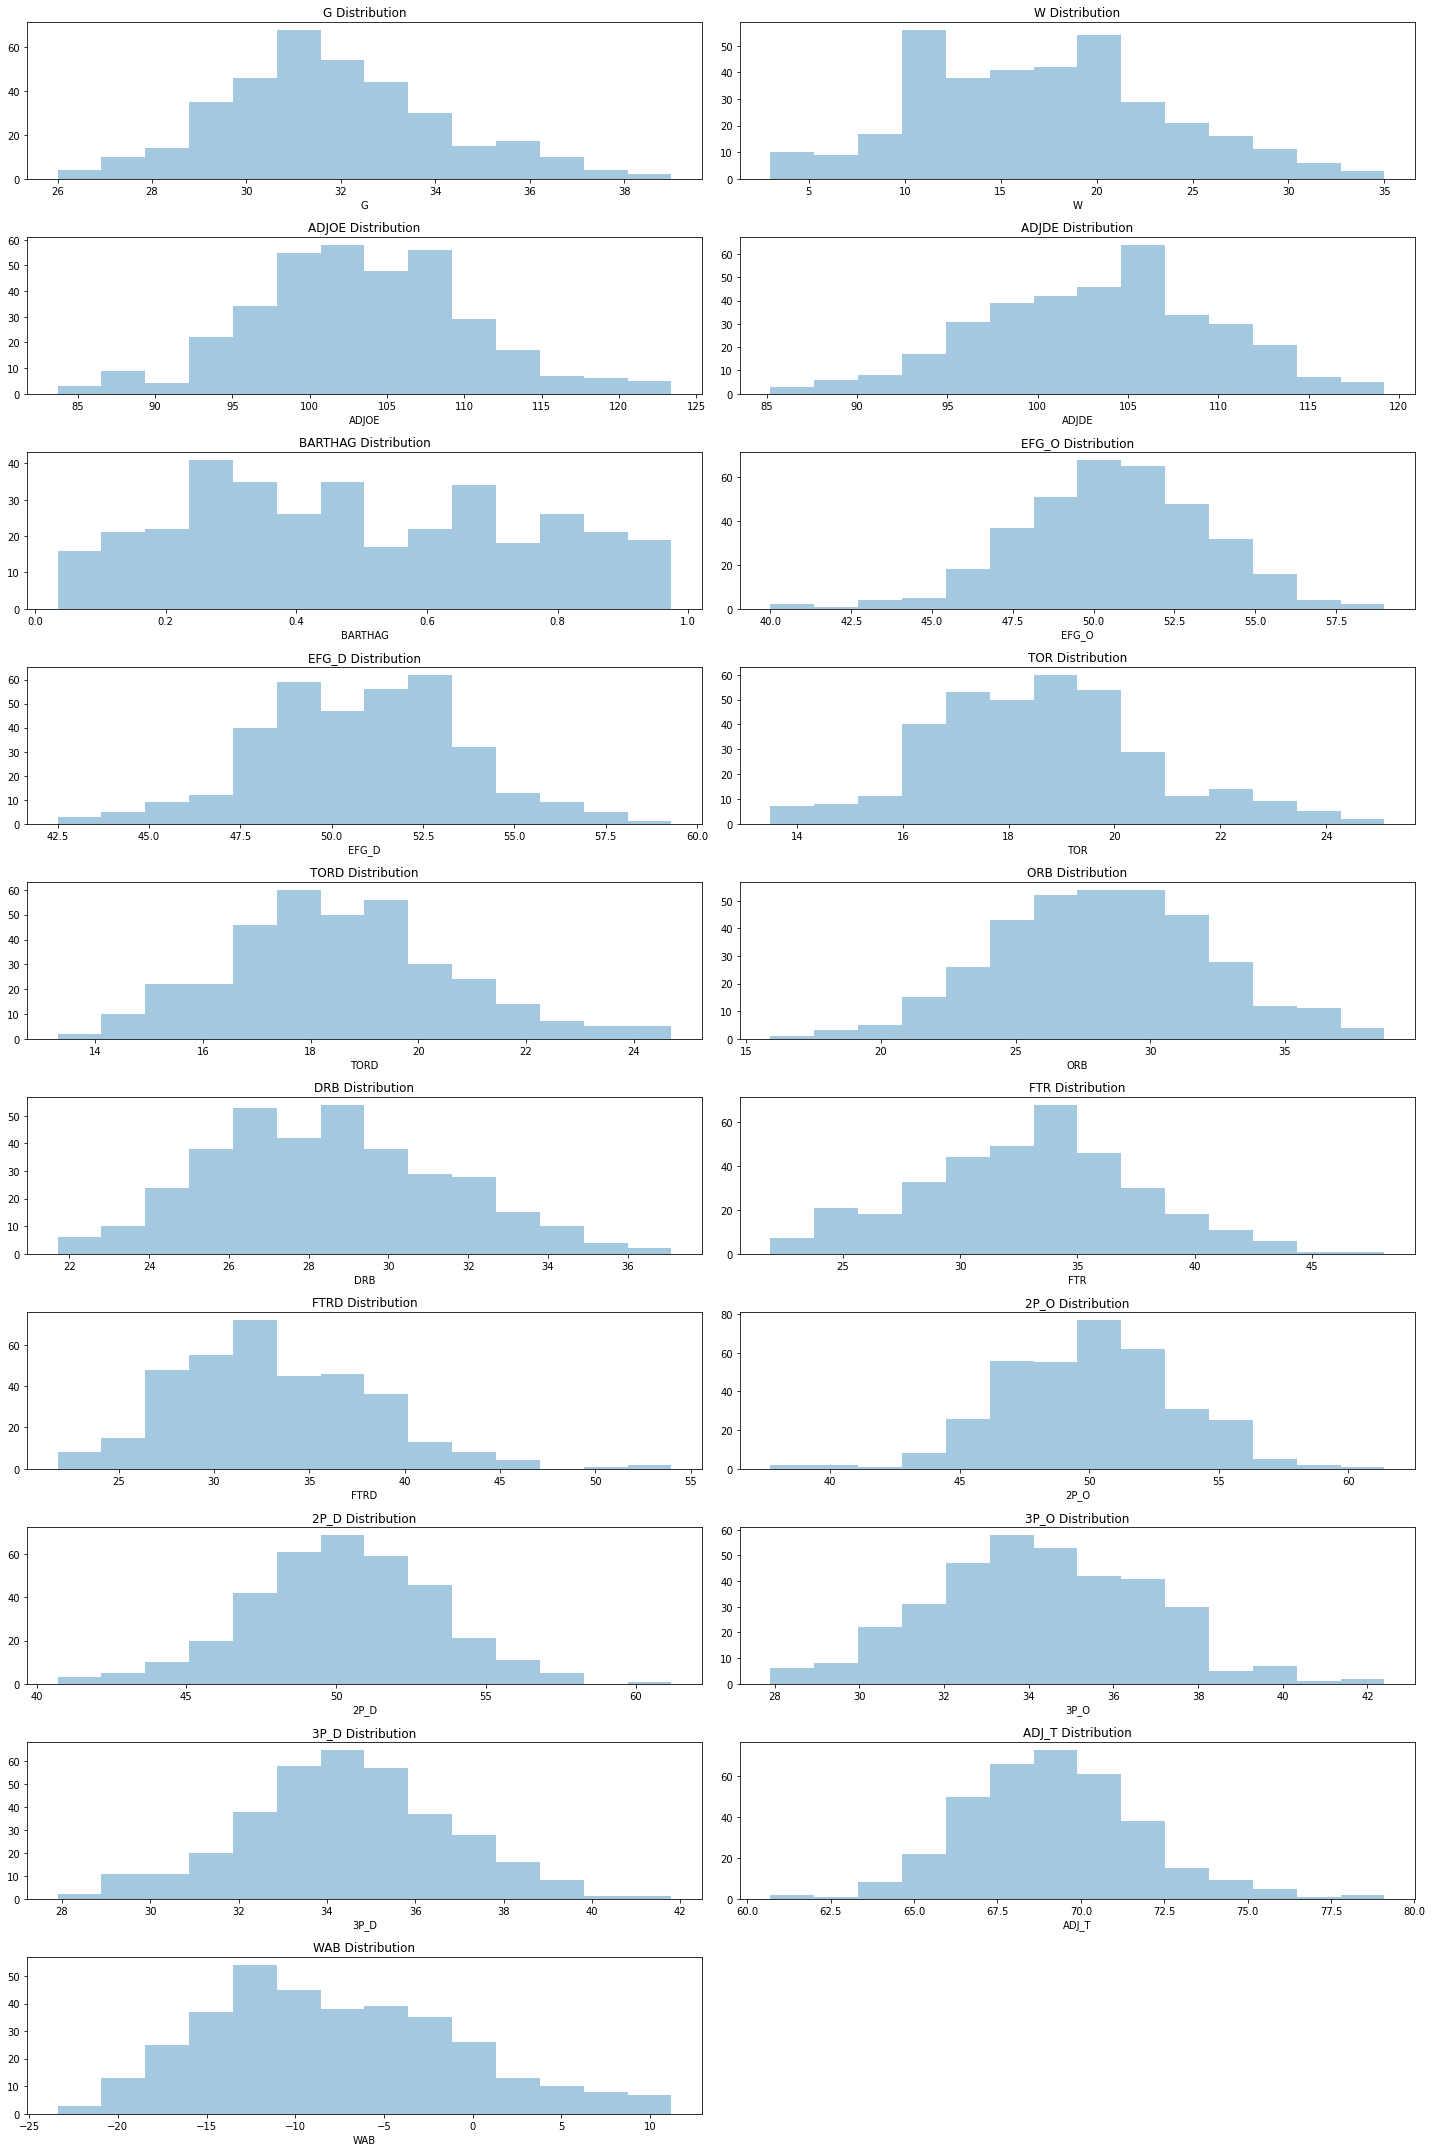

In [9]:
# Distribución de variables numpericas
fig=plt.figure(figsize=(20,30))
for i, feature in enumerate(columnas):
    ax=fig.add_subplot(10,2,i+1)
    sns.distplot(datos[feature], bins=14, kde=False)
    ax.set_title(feature+" Distribution")

fig.tight_layout()  
plt.show()

Podríamos empezar a identificar cuál es el comportamiento de los equipos durante la temporada 

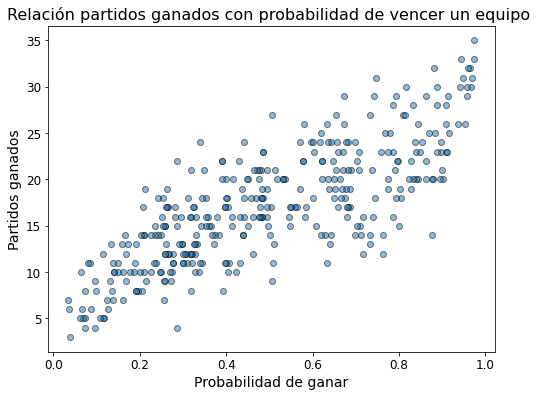

In [10]:
plt.figure(figsize=(8,6))

plt.scatter(datos['BARTHAG'], datos['W'],alpha=0.5, edgecolor='k')
plt.title('Relación partidos ganados con probabilidad de vencer un equipo ', fontsize=16)
plt.xlabel('Probabilidad de ganar', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Partidos ganados', fontsize=14)
plt.yticks(fontsize=12)
plt.show()

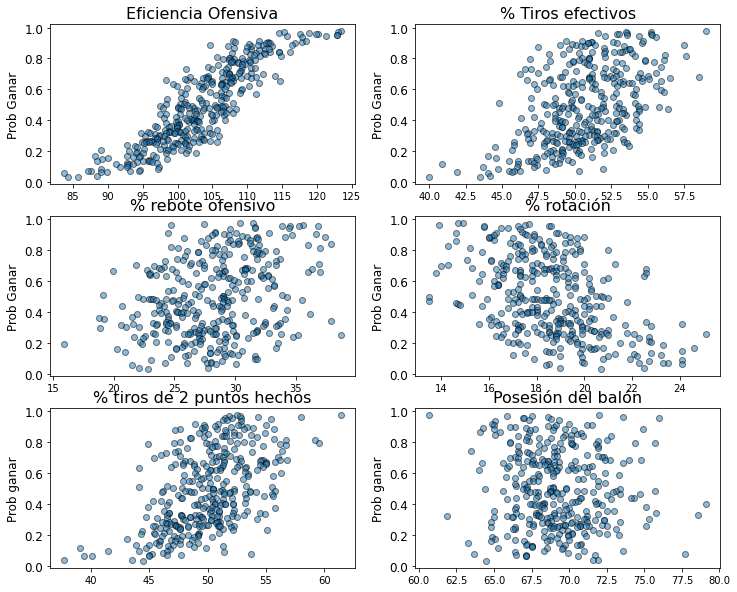

In [11]:
# Cómo se relacionan algunas variables con la probabilidad de ganar
plt.figure(figsize=(12,10))

plt.subplot(321)
plt.scatter(y=datos['BARTHAG'], x=datos['ADJOE'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Eficiencia Ofensiva', fontsize=16)

plt.subplot(322)
plt.scatter(y=datos['BARTHAG'], x=datos['EFG_O'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('% Tiros efectivos', fontsize=16)


plt.subplot(323)
plt.scatter(y=datos['BARTHAG'], x=datos['ORB'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('% rebote ofensivo', fontsize=16)


# Partidos ganados
plt.subplot(324)
plt.scatter(y=datos['BARTHAG'], x=datos['TOR'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob Ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('% rotación', fontsize=16)


plt.subplot(325)
plt.scatter(y=datos['BARTHAG'], x=datos['2P_O'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('% tiros de 2 puntos hechos', fontsize=16)


plt.subplot(326)
plt.scatter(y=datos['BARTHAG'], x=datos['ADJ_T'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Posesión del balón', fontsize=16)


plt.show()

Inspeccionemos las correlaciones existentes entre las variables numéricas

In [12]:
km_data = datos.drop(['TEAM','CONF','POSTSEASON','SEED'],axis=1)
km_data.head()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
0,37,33,123.4,89.9,0.9744,59.0,44.2,14.9,19.0,31.5,26.8,35.3,25.9,61.4,43.4,36.3,30.4,72.0,7.0
1,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,17.5,30.4,25.4,29.1,26.3,52.5,45.7,39.5,28.9,60.7,11.1
2,38,32,118.9,89.2,0.9646,53.6,45.0,17.5,19.4,35.6,29.5,33.2,24.0,58.0,45.0,30.8,29.9,73.6,11.2
3,36,29,120.1,91.4,0.9582,52.9,48.9,17.2,18.3,35.3,22.8,30.2,28.4,52.1,47.9,36.2,33.5,76.0,10.0
4,37,30,114.6,85.6,0.9665,51.6,44.1,13.9,18.0,24.7,24.8,27.5,24.1,51.8,44.3,34.2,29.1,65.9,9.2


In [13]:
corr = km_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
G,1.00,0.67,0.64,-0.63,0.71,0.32,-0.50,-0.32,0.18,0.29,-0.14,0.20,-0.21,0.32,-0.48,0.16,-0.34,-0.05,0.70
W,0.67,1.00,0.75,-0.68,0.79,0.59,-0.65,-0.46,0.23,0.32,-0.29,0.15,-0.26,0.57,-0.57,0.36,-0.51,-0.03,0.90
ADJOE,0.64,0.75,1.00,-0.57,0.88,0.70,-0.39,-0.58,-0.03,0.30,-0.21,0.07,-0.40,0.64,-0.36,0.47,-0.29,0.02,0.85
ADJDE,-0.63,-0.68,-0.57,1.00,-0.87,-0.23,0.82,0.22,-0.26,-0.26,0.31,-0.11,0.18,-0.30,0.74,-0.03,0.62,0.15,-0.83
BARTHAG,0.71,0.79,0.88,-0.87,1.00,0.51,-0.66,-0.45,0.13,0.31,-0.28,0.10,-0.33,0.52,-0.60,0.27,-0.50,-0.07,0.94
EFG_O,0.32,0.59,0.70,-0.23,0.51,1.00,-0.18,-0.36,-0.12,-0.11,-0.28,-0.05,-0.42,0.88,-0.16,0.73,-0.14,0.02,0.51
EFG_D,-0.50,-0.65,-0.39,0.82,-0.66,-0.18,1.00,0.13,-0.08,-0.25,0.21,-0.15,0.12,-0.23,0.89,-0.03,0.77,0.12,-0.69
TOR,-0.32,-0.46,-0.58,0.22,-0.45,-0.36,0.13,1.00,0.07,0.20,0.18,0.20,0.39,-0.28,0.11,-0.32,0.10,-0.03,-0.44
TORD,0.18,0.23,-0.03,-0.26,0.13,-0.12,-0.08,0.07,1.00,0.18,0.35,0.16,0.39,-0.04,-0.03,-0.18,-0.14,0.00,0.17
ORB,0.29,0.32,0.30,-0.26,0.31,-0.11,-0.25,0.20,0.18,1.00,0.05,0.25,0.17,-0.02,-0.25,-0.18,-0.17,-0.01,0.36


## Agrupamiento 

A partir del análisis exploratorio, escogemos algunas variables que parecen tener una mayor variabilidad y nos permitirán identificar tipos de equipos

In [14]:
km = km_data[['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB']]
km.head()

,W,ADJOE,BARTHAG,EFG_O,2P_O,WAB
0,33,123.4,0.9744,59.0,61.4,7.0
1,35,123.0,0.9736,55.2,52.5,11.1
2,32,118.9,0.9646,53.6,58.0,11.2
3,29,120.1,0.9582,52.9,52.1,10.0
4,30,114.6,0.9665,51.6,51.8,9.2


Al igual que en ACP es importante estandarizar las variables que vamos a utilizar. La función **StandardScaler** nos permite hacerlo en una sola linea

In [15]:
scaler = StandardScaler()
km_scale = scaler.fit_transform(km)
km_scale[0:5]

array([[2.49556925, 2.86217223, 1.90457765, 2.86224391, 3.37695893,
        2.07913073],
       [2.80974042, 2.80511144, 1.90141118, 1.56728827, 0.72659873,
        2.65574628],
       [2.33848367, 2.22023839, 1.86578838, 1.02204379, 2.36446178,
        2.66981008],
       [1.86722692, 2.39142075, 1.84045661, 0.78349933, 0.60748142,
        2.50104455],
       [2.0243125 , 1.60683495, 1.87330875, 0.34048819, 0.51814344,
        2.3885342 ]])

## Agrupamiento k-means

Utilizaremos la funcion KMeans de la librería sklearn https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Los principales argumentos que debemos dar a la función son:
- **n_clusters:** al ser un método particional debemos definir el número de clusters
- **init:** indica el método con el cuál vamos a escoger los puntos de inicio de los centroides 
- **random_state:** definir una semilla para poder reproducir 


Primero definimos los parámetros del algoritmo

In [16]:
kmeans = KMeans(
        #init = "kmean++"
        init="random",
        n_clusters=3,
        random_state=42  #semilla
    )

Ajustamos el algoritmo a los datos

In [17]:
kmeans.fit(km_scale)

KMeans(init='random', n_clusters=3, random_state=42)

Los atributos generados por el algoritmo son:

- **cluster_centers_:** los centroides de los clusters encontrados 
- **labels_:** la asignación de cluster para cada punto
- **inertia_:** suma de distancias cuadradas de cada punto a su centroide-Total Suma de cuadrados dentro  (comparar métodos)

In [18]:
print('La suma de distancias cuadradas de cada punto a su centroide en esta solución es de')
print(kmeans.inertia_)
print('Pero este número por si solo no es muy explicativo')

La suma de distancias cuadradas de cada punto a su centroide en esta solución es de
804.8894012533922
Pero este número por si solo no es muy explicativo


**Centroides**

Tener en cuenta que las variables están estandarizadas, no necesariamente estos valores tengan un significado explícito pero sus magnitudes y sentidos si nos pueden decir mucho sobre las variables originales

In [19]:
centroides = pd.DataFrame(kmeans.cluster_centers_)
centroides.columns = ['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB']
centroides

,W,ADJOE,BARTHAG,EFG_O,2P_O,WAB
0,1.123904,1.126966,1.195884,0.860789,0.847558,1.241393
1,-1.041504,-1.137372,-1.145788,-1.052489,-1.052465,-1.080166
2,-0.097754,-0.048440,-0.083985,0.060928,0.068600,-0.145391


Podríamos llegar a decir que los equipos del cluster 2 son quienes más han ganado partidos, mientras que los del cluster 0 son los del menor número de partidos ganados.

Revisemos cómo podemos relacionar el cluster con las variables originales

Guardamos la asignación del cluster en una nueva columna del data set

In [20]:
datos['cluster'] = kmeans.labels_

Y podemos visualizar cómo se comportan los clusters con respecto a las variables originales

Text(0.5, 1.0, 'Partidos ganados según cluster')

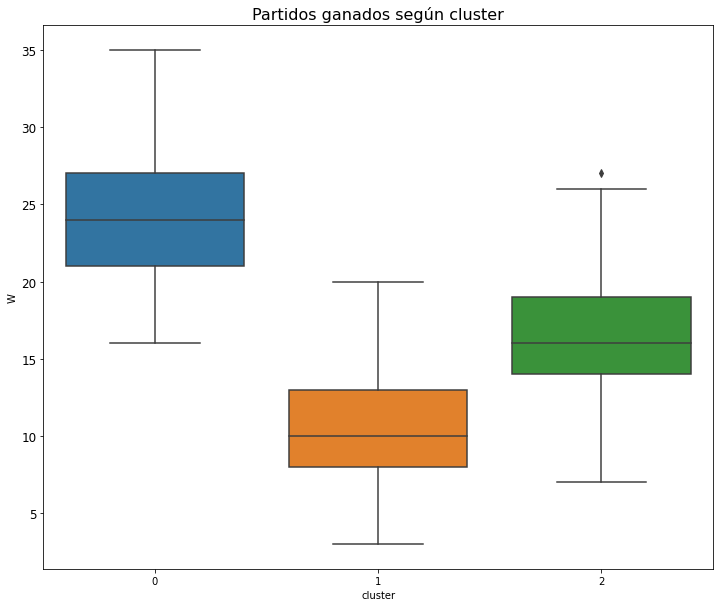

In [21]:
plt.figure(figsize=(12,10))

sns.boxplot(y=datos['W'],x=datos['cluster'])
plt.yticks(fontsize=12)
plt.title('Partidos ganados según cluster', fontsize=16)

In [22]:
datos.groupby('cluster')['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,W,ADJOE,BARTHAG,EFG_O,2P_O,WAB
cluster,,,,,,
0,24.268041,111.236082,0.795351,53.126804,52.906186,1.043299
1,10.483146,95.362921,0.203734,47.512360,46.525843,-15.464045
2,16.491018,102.996407,0.471995,50.779641,50.290419,-8.817365


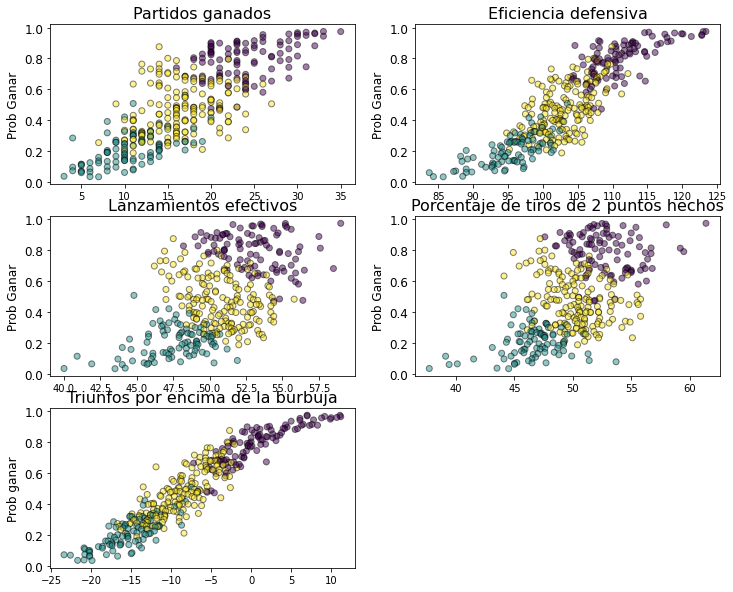

In [23]:
# Relacion con probabilidad de ganar por cluster
plt.figure(figsize=(12,10))

plt.subplot(321)
plt.scatter(y=datos['BARTHAG'], x=datos['W'],c=datos['cluster'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Partidos ganados', fontsize=16)

plt.subplot(322)
plt.scatter(y=datos['BARTHAG'], x=datos['ADJOE'],c=datos['cluster'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Eficiencia defensiva', fontsize=16)


plt.subplot(323)
plt.scatter(y=datos['BARTHAG'], x=datos['EFG_O'],c=datos['cluster'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Lanzamientos efectivos', fontsize=16)


# Partidos ganados
plt.subplot(324)
plt.scatter(y=datos['BARTHAG'], x=datos['2P_O'],c=datos['cluster'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob Ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Porcentaje de tiros de 2 puntos hechos', fontsize=16)


plt.subplot(325)
plt.scatter(y=datos['BARTHAG'], x=datos['WAB'],c=datos['cluster'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Triunfos por encima de la burbuja', fontsize=16)




plt.show()

## Agrupamiento jerárquico

En el agrupamiento jerárquico primero podemos inspeccionar cuántos clusters debería considerar el algoritmo usando el dendograma. Para hacer esto utilizaremos las funciones **linkage** (https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) y **dendogram** (https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) de la librería **scipy**

Para el linkage utilizaremos el método ward que minimiza la varianza dentro de los clusters

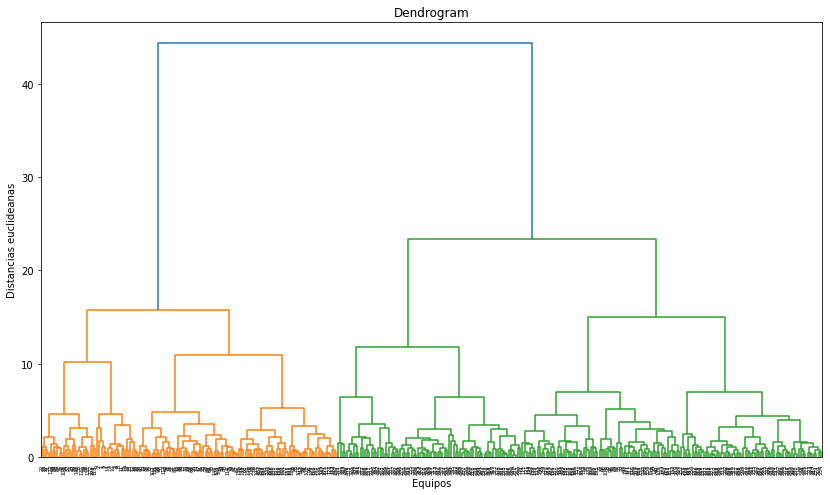

In [24]:
plt.figure(figsize=(14,8))
dendrogram = sch.dendrogram(sch.linkage(km_scale, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Equipos')
plt.ylabel('Distancias euclideanas')
plt.show()

El gráfico nos muestra las ramificaciones de posibles clusters y nos puede indicar un buen número de clusters. Para continuar con la lógica del k-means anterior utilizaremos el agrupamiento de 3 clusters. Para hacer el ajuste del algoritmo utilizaremos la función **AgglomerativeClustering** de sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

In [25]:
jer = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')

Guardemos el cluster asignado a cada observación

In [26]:
datos['cluster_j']= jer.fit_predict(km_scale)

Comparemos los resultados del k-means con el jerárquico. 


**Nota:** Los algoritmos no necesariamente van a dar las mismas etiquetas a cada observación, esto incluso si se corre el mismo k-means varias veces los resultados pueden ser diferentes. Lo que queremos es analizar que tan similar es la asignación de clusters

In [27]:
# Comparación de los clusters kmeans y jerárquicos
pd.crosstab(datos['cluster'],datos['cluster_j'])

cluster_j,0,1,2
cluster,,,
0,97,0,0
1,0,7,82
2,37,129,1


Podríamos inferir que el cluster 0 en el k-means tiene una composición similar para el cluster 2 en el jerárquico, y viceversa. Revisemos cómo se comportan los clusters con respecto a las variables observadas 

Text(0.5, 1.0, 'Partidos ganados según cluster jerárquico')

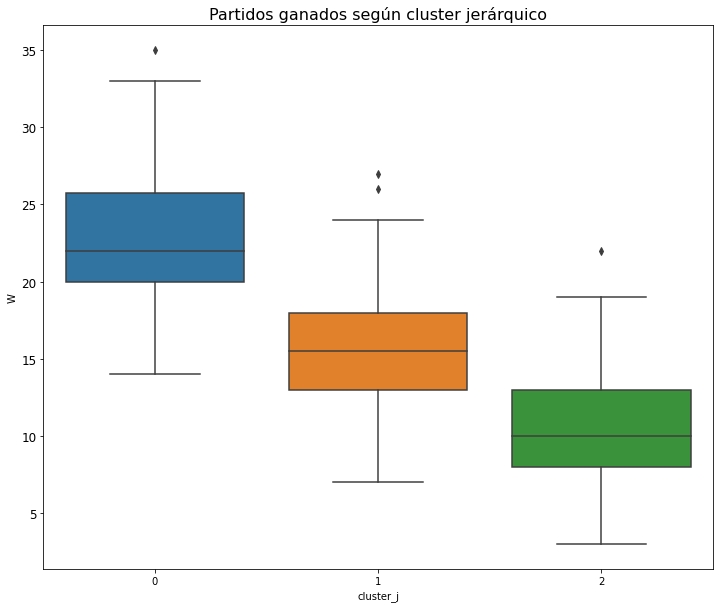

In [28]:
plt.figure(figsize=(12,10))
sns.boxplot(y=datos['W'],x=datos['cluster_j'])
plt.yticks(fontsize=12)
plt.title('Partidos ganados según cluster jerárquico', fontsize=16)

In [29]:
datos.groupby('cluster_j')['W','ADJOE','BARTHAG','EFG_O','2P_O','WAB'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,W,ADJOE,BARTHAG,EFG_O,2P_O,WAB
cluster_j,,,,,,
0,22.761194,109.785821,0.727410,52.926866,52.573881,-1.129104
1,15.661765,102.105147,0.445736,50.205147,49.770588,-9.488971
2,10.373494,94.939759,0.192910,47.493976,46.475904,-15.732530


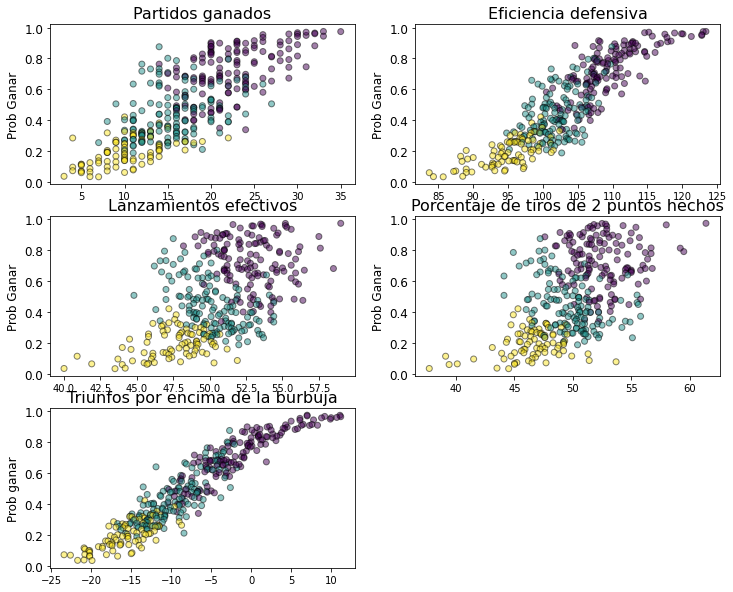

In [30]:
plt.figure(figsize=(12,10))

plt.subplot(321)
plt.scatter(y=datos['BARTHAG'], x=datos['W'],c=datos['cluster_j'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Partidos ganados', fontsize=16)

plt.subplot(322)
plt.scatter(y=datos['BARTHAG'], x=datos['ADJOE'],c=datos['cluster_j'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Eficiencia defensiva', fontsize=16)


plt.subplot(323)
plt.scatter(y=datos['BARTHAG'], x=datos['EFG_O'],c=datos['cluster_j'],alpha=0.5, edgecolor='k')
plt.yticks(fontsize=12)
plt.ylabel('Prob Ganar', fontsize=12)
plt.title('Lanzamientos efectivos', fontsize=16)


# Partidos ganados
plt.subplot(324)
plt.scatter(y=datos['BARTHAG'], x=datos['2P_O'],c=datos['cluster_j'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob Ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Porcentaje de tiros de 2 puntos hechos', fontsize=16)


plt.subplot(325)
plt.scatter(y=datos['BARTHAG'], x=datos['WAB'],c=datos['cluster_j'],alpha=0.5, edgecolor='k')
plt.ylabel('Prob ganar', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Triunfos por encima de la burbuja', fontsize=16)
plt.show()

## DBSCAN

Ajustamos también un DBSCAN a nuestros datos

In [31]:
# min_samples: mínimo de puntos en el sector de influencia
m = DBSCAN(eps=0.70, min_samples=10)
m.fit(km_scale)

DBSCAN(eps=0.7, min_samples=10)

In [32]:
datos['cluster_db'] = m.labels_

In [33]:
# los clusters son los contados desde el índice cero, en este caso
# encontró 4 clusters
# cluster -1: puntos para los que no encuentra un closter. Son datos atípicos
datos.cluster_db.value_counts()

-1    278
 2     39
 1     17
 0     10
 3      9
Name: cluster_db, dtype: int64

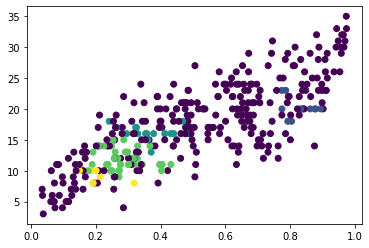

In [34]:
plt.scatter(datos['BARTHAG'], datos['W'], c=datos['cluster_db'])

En este caso particular DBSCAN no parece ser una buena solución. Sólo identifica 4 clusters pero la gran mayoría de puntos quedan identificados como noise points

## Ejercicios

1. Analizando los clusters formados por el k-means ¿Qué nombres le podríamos asignar a cada uno de los clusters que identifiquen sus comportamientos?
2. ¿Podríamos utilizar estos nombres para los resultados del jerárquico?
3. En el dendograma del agrupamiento jerárquico vimos que 5 clusters podría ser una solución. Ajustemos tanto para k-means como para el jerárquico nuevos agrupamientos utilizando 5 clusters. ¿Qué podemos concluir? ¿Cuál sería la mejor solución?

## Conclusiones

- Efectivamente se logran diferenciar tres grandes segmentos en los equipos caracterizados por su desempeño
- Se pueden identificar patrones en las métricas que permitan definir umbrales mínimos para los indicadores de rendimiento
- Se requiere de mayor información para escoger el número de clusters (más adelante lo veremos)